# **Nom du Projet**    -  **Prediction du prix d'une voiture d'occasion sur Leboncoin**

##### **Type de Projet**    - Regression
##### **Contribution**    - Groupe : Ismael DEMBELE & Anne Laure

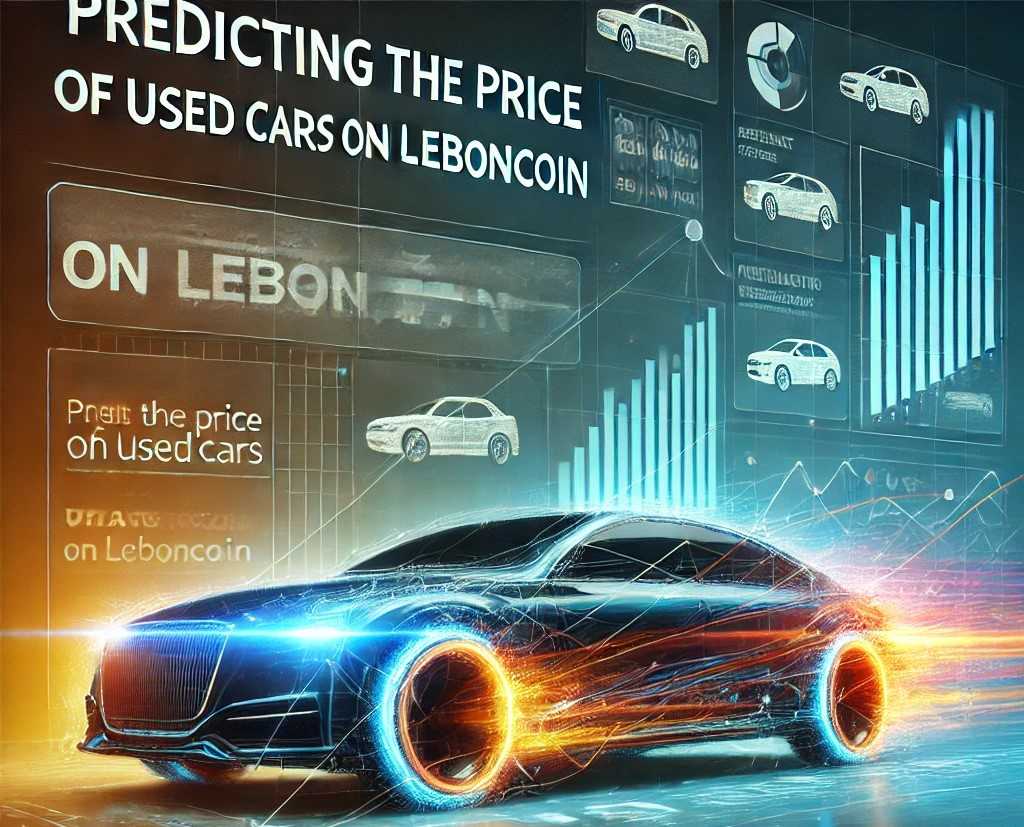

# **Résumé du projet -**


Ce projet vise à analyser le marché des produits d’occasion en France, en se concentrant sur les annonces publiées sur des plateformes comme LeBonCoin. L’objectif principal est de comprendre les facteurs influençant le prix des produits, notamment les voitures, en exploitant des données collectées directement sur ces plateformes. Ce notebook présente une démarche structurée allant de la collecte des données au développement d’un modèle prédictif, tout en intégrant une analyse descriptive pour explorer les tendances du marché. Il s’agit d’un exercice pratique en data science combinant scraping, exploration des données et modélisation pour répondre à des questions concrètes sur le marché de l’occasion.

# **Index**

1.   Énoncé du problème
2.   Connaître ses données
3.   Comprendre les variables
4.   L'IDD
5.   Nettoyage des données
6.   Ingénierie des caractéristiques
7.   Construction de modèles
8.   Mise en œuvre du modèle.
9.   Conclusion

# **C'est parti !**

## **1. Énoncé du problème**

## **2. Préparation des données**

### Importation des Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Chargement des donnees 

In [2]:
leboncoin_ads=pd.read_json(os.getcwd()+"/Data/leboncoin_ads.json")
df=leboncoin_ads.copy()
df.head()

,list_id,first_publication_date,expiration_date,index_date,status,category_id,category_name,subject,body,brand,...,images,attributes,location,owner,options,has_phone,similar,counters,is_boosted,extended_attributes
0,2915147681,2025-01-07 16:17:34,2025-03-08 16:17:34,2025-01-07 16:17:34,active,2,Voitures,BMW série 1 Pack M Sport,,leboncoin,...,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'activity_sector', 'value': '1', 'val...","{'country_id': 'FR', 'region_id': '1', 'region...","{'store_id': '36203103', 'user_id': '171ca0e6-...","{'has_option': False, 'booster': False, 'photo...",True,NaN,{},NaN,NaN
1,2906060394,2024-12-19 12:33:00,NaN,2025-01-07 16:15:46,active,2,Voitures,Mercedes Classe A 180 d Progressive Line Siège...,,leboncoin,...,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'activity_sector', 'value': '1', 'val...","{'country_id': 'FR', 'region_id': '1', 'region...","{'store_id': '43500944', 'user_id': '5569eaa8-...","{'has_option': False, 'booster': False, 'photo...",True,NaN,{},1.0,NaN
2,2906056677,2024-12-19 14:08:00,NaN,2025-01-07 16:15:46,active,2,Voitures,Mercedes Classe A 250 e AMG Line -Pack Premium,,leboncoin,...,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'activity_sector', 'value': '1', 'val...","{'country_id': 'FR', 'region_id': '1', 'region...","{'store_id': '191246', 'user_id': '82c6d06c-bc...","{'has_option': False, 'booster': False, 'photo...",True,NaN,{},1.0,NaN
3,2901139970,2024-12-10 09:30:00,NaN,2025-01-07 16:15:46,active,2,Voitures,Volkswagen Golf 1.5 eTSI OPF 150ch R-Line DSG7,,leboncoin,...,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'activity_sector', 'value': '1', 'val...","{'country_id': 'FR', 'region_id': '1', 'region...","{'store_id': '29739690', 'user_id': 'b82f7487-...","{'has_option': False, 'booster': False, 'photo...",True,NaN,{},1.0,NaN
4,2895925882,2024-12-03 09:20:00,NaN,2025-01-07 16:15:46,active,2,Voitures,Renault Captur E-Tech Plug-in 160 Intens,,leboncoin,...,{'thumb_url': 'https://img.leboncoin.fr/api/v1...,"[{'key': 'activity_sector', 'value': '1', 'val...","{'country_id': 'FR', 'region_id': '1', 'region...","{'store_id': '175824', 'user_id': 'd92ae14f-f9...","{'has_option': False, 'booster': False, 'photo...",True,NaN,{},1.0,NaN


### Nombre de lignes et colonnes

In [3]:
df.shape

(81710, 24)

In [4]:
print(f"nombre d'annonces  : {df.shape[0]}  \nnombre de colonnes : {df.shape[1]}")

nombre d'annonces  : 81710  
nombre de colonnes : 24


### Information sur les donnees

In [5]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81710 entries, 0 to 81709
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   list_id                 81710 non-null  int64  
 1   first_publication_date  81710 non-null  object 
 2   expiration_date         29736 non-null  object 
 3   index_date              81710 non-null  object 
 4   status                  81710 non-null  object 
 5   category_id             81710 non-null  int64  
 6   category_name           81710 non-null  object 
 7   subject                 81710 non-null  object 
 8   body                    81710 non-null  object 
 9   brand                   81710 non-null  object 
 10  ad_type                 81710 non-null  object 
 11  url                     81710 non-null  object 
 12  price                   81710 non-null  object 
 13  price_cents             81710 non-null  int64  
 14  images                  81710 non-null

In [6]:
#Les colonnes
df.columns

Index(['list_id', 'first_publication_date', 'expiration_date', 'index_date',
       'status', 'category_id', 'category_name', 'subject', 'body', 'brand',
       'ad_type', 'url', 'price', 'price_cents', 'images', 'attributes',
       'location', 'owner', 'options', 'has_phone', 'similar', 'counters',
       'is_boosted', 'extended_attributes'],
      dtype='object')

In [7]:
#compter le nombre de modalités par column
def count_modalities(dataset):
    compteur={}
    for column_name in dataset.columns:
        try:
            compteur[column_name]=len(set(dataset[column_name]))
        except TypeError as e:
            compteur[column_name]=str(e)
            pass
    return compteur
count_modalities(df)

{'list_id': 80783,
 'first_publication_date': 65304,
 'expiration_date': 24962,
 'index_date': 29195,
 'status': 1,
 'category_id': 1,
 'category_name': 1,
 'subject': 57754,
 'body': 1,
 'brand': 1,
 'ad_type': 1,
 'url': 80783,
 'price': "unhashable type: 'list'",
 'price_cents': 5596,
 'images': "unhashable type: 'dict'",
 'attributes': "unhashable type: 'list'",
 'location': "unhashable type: 'dict'",
 'owner': "unhashable type: 'dict'",
 'options': "unhashable type: 'dict'",
 'has_phone': 2,
 'similar': 81710,
 'counters': "unhashable type: 'dict'",
 'is_boosted': 49302,
 'extended_attributes': "unhashable type: 'dict'"}

On distingue de nombreux dictionnnaires et listes en colonne qu'il va falloir traiter pour en extraire les informations les plus pertinentes, pour raffiner notre jeu de donnees afin d'entamer serenement la phase descriptive.

In [8]:
# Étape 3 : Nettoyage des données
# Suppression des colonnes inutiles ou redondantes
colonnes_existantes = set(df.columns)
colonnes_a_supprimer = {
    'index_date', 'subject', 'body', 'brand', 'ad_type', 'options',
    'owner', 'has_phone', 'status', 'price_cents', 'images', 'similar', 'counters', 
    'extended_attributes', 'expiration_date', 'options.has_option', 
    'options.photosup', 'options.gallery', 'options.sub_toplist', 
    'options.continuous_top_ads', 'options.highlight', 'category_id', 'category_name'
}
df = df.drop(columns=colonnes_existantes & colonnes_a_supprimer, errors='ignore')

In [9]:
#Suppression des doublons
df = df.drop_duplicates(subset=['list_id'])

In [10]:
# Étape 4 : Traitement des valeurs manquantes
# Supprimer les lignes où les colonnes essentielles sont manquantes
colonnes_essentielles = ['price', 'attributes']
df = df.dropna(subset=colonnes_essentielles)

In [11]:
# Étape 5 : Extraction des données imbriquées
# Extraire les attributs clés depuis la colonne 'attributes'
def extraire_attributs_vectorise(attributes, keys):
    if not isinstance(attributes, list):
        return {key: None for key in keys}
    
    result = {key: None for key in keys}
    for attr in attributes:
        key = attr.get('key')
        if key in keys:
            result[key] = attr.get('value_label')
    return result

# Liste des clés à extraire
keys_to_extract = [
    'brand', 'model', 'fuel', 'mileage', 'regdate', 'gearbox', 'doors', 'seats',
    'vehicle_technical_inspection_a', 'issuance_date', 'vehicle_damage', 'vehicle_type',
    'vehicle_upholstery', 'vehicule_color', 'horsepower', 'horse_power_din',
    'vehicle_is_eligible_p2p', 'vehicle_history_report_public_url',
    'licence_plate_available', 'critair', 'gross_vehicle_weight', 'vehicle_interior_specs'
]

In [12]:
# Extraction vectorisée des attributs
extracted_attributes = df['attributes'].apply(lambda x: extraire_attributs_vectorise(x, keys_to_extract))
extracted_df = pd.DataFrame(list(extracted_attributes))

# Fusionner les attributs extraits avec le DataFrame principal
df = pd.concat([df, extracted_df], axis=1)

# Suppression de la colonne 'attributes' après extraction
df = df.drop(columns=['attributes'], errors='ignore')

In [13]:
# Extraire les données de localisation
def extraire_localisation(location, key):
    if isinstance(location, dict):
        return location.get(key)
    return None

df['region_name'] = df['location'].apply(lambda x: extraire_localisation(x, 'region_name'))
df['department_name'] = df['location'].apply(lambda x: extraire_localisation(x, 'department_name'))
df['city'] = df['location'].apply(lambda x: extraire_localisation(x, 'city'))
df['zipcode'] = df['location'].apply(lambda x: extraire_localisation(x, 'zipcode'))
df['lat'] = df['location'].apply(lambda x: extraire_localisation(x, 'lat'))
df['lng'] = df['location'].apply(lambda x: extraire_localisation(x, 'lng'))

In [14]:
# Suppression de la colonne 'location' après extraction
df = df.drop(columns=['location'], errors='ignore')

In [15]:
# Étape 6 : Transformation des données
# Convertir le kilometrage et le prix en numérique
df['mileage'] = df['mileage'].str.replace(' km', '').str.replace(r'\s+', '').astype(float)
df['price'] = df['price'].apply(lambda x: x[0] if isinstance(x, list) else x).astype(float)

# Harmoniser les colonnes de texte
df['brand'] = df['brand'].str.lower()
df['model'] = df['model'].str.lower()

In [16]:
# Étape 7 : Renommer les colonnes pour une meilleure lisibilité
colonnes_renommees = {
    'list_id': 'identifiant',
    'first_publication_date': 'date_publication',
    'url': 'lien_annonce',
    'price': 'prix',
    'is_boosted': 'booste',
    'brand': 'marque',
    'model': 'modele',
    'fuel': 'carburant',
    'mileage': 'kilometrage',
    'regdate': 'annee_modele',
    'gearbox': 'boite_vitesse',
    'doors': 'portes',
    'seats': 'places',
    'vehicle_technical_inspection_a': 'controle_technique',
    'issuance_date': 'date_mise_en_circulation',
    'vehicle_damage': 'etat_vehicule',
    'vehicle_type': 'type_vehicule',
    'vehicle_upholstery': 'sellerie',
    'vehicule_color': 'couleur',
    'horsepower': 'puissance_fiscale',
    'horse_power_din': 'puissance_din',
    'vehicle_is_eligible_p2p': 'eligible_p2p',
    'vehicle_history_report_public_url': 'rapport_historique',
    'licence_plate_available': 'plaque_disponible',
    'critair': 'critair',
    'gross_vehicle_weight': 'poids_total_autorise',
    'vehicle_interior_specs': 'equipements_interieurs',
    'region_name': 'region',
    'department_name': 'departement',
    'city': 'ville',
    'zipcode': 'code_postal',
    'lat': 'latitude',
    'lng': 'longitude'
}
df = df.rename(columns=colonnes_renommees)

In [17]:
#compter le nombre de modalités par column
count_modalities(df)

{'identifiant': 81706,
 'date_publication': 65305,
 'lien_annonce': 80784,
 'prix': 6519,
 'booste': 49807,
 'marque': 84,
 'modele': 643,
 'carburant': 8,
 'kilometrage': 34028,
 'annee_modele': 67,
 'boite_vitesse': 3,
 'portes': 7,
 'places': 9,
 'controle_technique': 21,
 'date_mise_en_circulation': 771,
 'etat_vehicule': 4,
 'type_vehicule': 11,
 'sellerie': 76,
 'couleur': 19,
 'puissance_fiscale': 91,
 'puissance_din': 516,
 'eligible_p2p': 4,
 'rapport_historique': 39643,
 'plaque_disponible': 3,
 'critair': 9,
 'poids_total_autorise': 109,
 'equipements_interieurs': 1858,
 'region': 26,
 'departement': 67,
 'ville': 5647,
 'code_postal': 3111,
 'latitude': 10244,
 'longitude': 10331}

In [18]:
print(df.isnull().sum())

identifiant                   923
date_publication              923
lien_annonce                  923
prix                          923
booste                      49806
marque                       1292
modele                       1577
carburant                     923
kilometrage                   923
annee_modele                  923
boite_vitesse                 923
portes                       5124
places                       6745
controle_technique          69339
date_mise_en_circulation     3876
etat_vehicule               63798
type_vehicule                4879
sellerie                    63008
couleur                      4945
puissance_fiscale            6101
puissance_din               11865
eligible_p2p                59401
rapport_historique          42065
plaque_disponible           21143
critair                     28248
poids_total_autorise        81557
equipements_interieurs      64749
region                        923
departement                  3513
ville         

In [19]:
# Étape 9 : Gestion des valeurs manquantes

colonnes_a_supprimer = {
    'poids_total_autorise', 'eligible_p2p'
}
df = df.drop(columns= colonnes_a_supprimer, errors='ignore')

# Suppression des lignes où 'modele' ou 'prix' sont manquants
df = df.dropna(subset=['modele', 'prix'])

In [20]:
# Imputation avec la valeur la plus fréquente pour certaines colonnes
colonnes_imputees_mode = ['portes', 'puissance_fiscale', 'puissance_din', 'date_mise_en_circulation', 'places']
for colonne in colonnes_imputees_mode:
    mode = df[colonne].mode()[0]  # Trouver la valeur la plus fréquente
    df.loc[:, colonne] = df[colonne].fillna(mode)

In [21]:
# Remplacement par 'non_specifie' pour certaines colonnes catégoriques
colonnes_non_specifie = ['controle_technique', 'etat_vehicule', 'equipements_interieurs', 'sellerie',
                         'rapport_historique', 'critair', 'plaque_disponible', 'type_vehicule', 'couleur', 'booste']
df.loc[:, colonnes_non_specifie] = df[colonnes_non_specifie].fillna('non_specifie')

C:\Users\Annek\AppData\Local\Temp\ipykernel_21456\391446790.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['non_specifie' 1.0 1.0 ... 'non_specifie' 'non_specifie' 'non_specifie']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, colonnes_non_specifie] = df[colonnes_non_specifie].fillna('non_specifie')


In [22]:
# Étape 1 : Créer un mapping ville-département à partir des données existantes
ville_departement_mapping = df[['ville', 'departement']].dropna().drop_duplicates().set_index('ville')['departement'].to_dict()

# Étape 2 : Remplir les valeurs manquantes dans la colonne 'departement' en utilisant le mapping
def remplir_departement(row):
    if pd.notna(row['departement']):
        return row['departement']
    elif row['ville'] in ville_departement_mapping:
        return ville_departement_mapping[row['ville']]
    return None

df['departement'] = df.apply(remplir_departement, axis=1)

print(df['departement'].isnull().sum(), "valeurs manquantes restantes dans 'departement'")

1560 valeurs manquantes restantes dans 'departement'


In [23]:
# Étape 3 : Compléter avec la colonne 'région' si 'departement' est toujours manquant
region_departement_mapping = df[['region', 'departement']].dropna().drop_duplicates().set_index('region')['departement'].to_dict()

df['departement'] = df.apply(
    lambda row: region_departement_mapping[row['region']] if pd.isna(row['departement']) and row['region'] in region_departement_mapping else row['departement'],
    axis=1
)

print(df['departement'].isnull().sum(), "valeurs manquantes restantes dans 'departement'")

265 valeurs manquantes restantes dans 'departement'


In [24]:
# Remplir les valeurs manquantes de la colonne 'departement' par 'Guyane' car il s'agit de ville de la Guyane
df['departement'] = df['departement'].fillna('Guyane')

<Axes: >

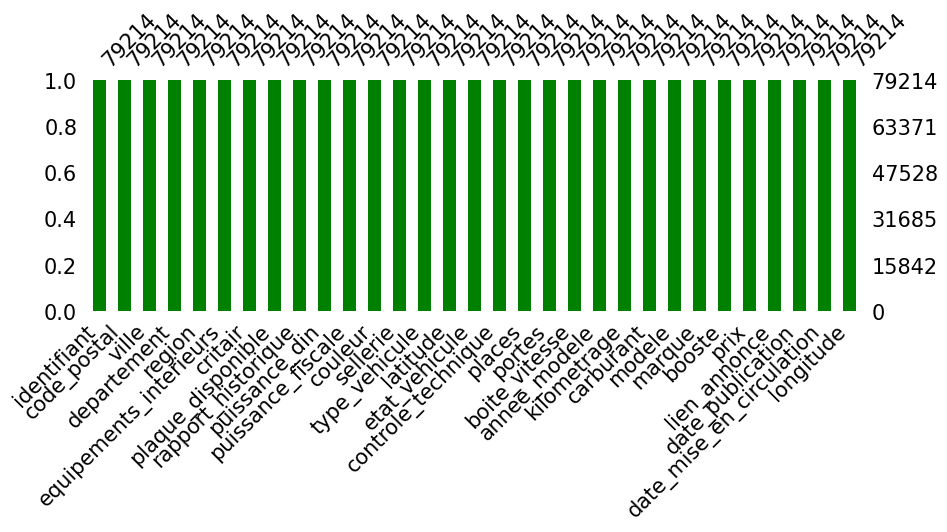

In [25]:
# Visualizing the missing values
import missingno as msno
msno.bar(df, color='green',sort='ascending', figsize=(10,3), fontsize=15)

In [26]:
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
print(df.head(2))  # Affiche les premières lignes du DataFrame

    identifiant     date_publication  \
0  2.915148e+09  2025-01-07 16:17:34   
1  2.906060e+09  2024-12-19 12:33:00   

                                      lien_annonce     prix        booste  \
0  https://www.leboncoin.fr/ad/voitures/2915147681  11490.0  non_specifie   
1  https://www.leboncoin.fr/ad/voitures/2906060394  24990.0           1.0   

     marque    modele carburant  kilometrage annee_modele boite_vitesse  \
0       bmw   serie 1   Essence      99500.0         2013      Manuelle   
1  mercedes  classe a    Diesel      89785.0         2020   Automatique   

  portes places controle_technique date_mise_en_circulation  etat_vehicule  \
0      5      5               2027                  05/2013  Non endommagé   
1      5      5       non_specifie                  07/2020   non_specifie   

  type_vehicule      sellerie couleur puissance_fiscale puissance_din  \
0       Berline     Alcantara   Blanc              7 Cv        136 Ch   
1       Berline  non_specifie    Gris   

### Preparation pour Statistiques Descriptives

In [27]:
# Étape 10 : Suppression des colonnes inutiles
# Supprimer 'identifiant' et 'lien_annonce'
df_cleaned = df.drop(columns=['identifiant', 'lien_annonce'], errors='ignore')

In [28]:
# Étape 11 : Transformation en booléens
# Transformer 'booste', 'rapport_historique', 'plaque_disponible', 'equipements_interieurs' en booléens
colonnes_bool = ['booste', 'rapport_historique', 'plaque_disponible', 'equipements_interieurs']
for col in colonnes_bool:
    df_cleaned[col] = df_cleaned[col].apply(lambda x: False if x == 'non_specifie' else True)

In [29]:
# Étape 12 : Conversion des colonnes numériques textuelles
# Convertir 'puissance_fiscale' et 'puissance_din' en numériques
colonnes_numeriques = ['puissance_fiscale', 'puissance_din']
for col in colonnes_numeriques:
    df_cleaned[col] = df_cleaned[col].str.replace(' Cv', '').str.replace(' Ch', '').astype(float)

In [30]:
# Étape 13 : Transformation des dates
# Convertir 'date_publication' et 'date_mise_en_circulation' en datetime
df_cleaned['date_publication'] = pd.to_datetime(df_cleaned['date_publication'], errors='coerce')
df_cleaned['date_mise_en_circulation'] = pd.to_datetime(df_cleaned['date_mise_en_circulation'], format='%m/%Y', errors='coerce')

In [31]:
# Étape 14 : Création d'indicateurs dérivés
# Calculer l'âge du véhicule
current_year = pd.Timestamp.now().year
df_cleaned['age_vehicule'] = current_year - df_cleaned['date_mise_en_circulation'].dt.year

In [32]:
# Calculer le prix par kilomètre
df_cleaned['prix_par_km'] = df_cleaned['prix'] / df_cleaned['kilometrage']
df_cleaned['prix_par_km'] = df_cleaned['prix_par_km'].replace([np.inf, -np.inf], np.nan)  # Gérer les divisions par zéro

In [33]:
df_cleaned = pd.DataFrame(df_cleaned)
df_cleaned.to_csv('Data/df_cleaned.csv', index=False)

## **3. Comprendre les variables**

In [34]:
df_cleaned = pd.read_csv('Data/df_cleaned.csv')
df_cleaned.head(2)

,date_publication,prix,booste,marque,modele,carburant,kilometrage,annee_modele,boite_vitesse,portes,places,controle_technique,date_mise_en_circulation,etat_vehicule,type_vehicule,sellerie,couleur,puissance_fiscale,puissance_din,rapport_historique,plaque_disponible,critair,equipements_interieurs,region,departement,ville,code_postal,latitude,longitude,age_vehicule,prix_par_km
0,2025-01-07 16:17:34,11490.0,False,bmw,serie 1,Essence,99500.0,2013,Manuelle,5,5,2027,2013-05-01,Non endommagé,Berline,Alcantara,Blanc,7.0,136.0,False,False,non_specifie,True,Alsace,Bas-Rhin,Bischwiller,67240,48.76828,7.85898,12.0,0.115477
1,2024-12-19 12:33:00,24990.0,True,mercedes,classe a,Diesel,89785.0,2020,Automatique,5,5,non_specifie,2020-07-01,non_specifie,Berline,non_specifie,Gris,6.0,116.0,False,True,2,False,Alsace,Bas-Rhin,Obernai,67210,48.46231,7.48467,5.0,0.278332


In [35]:
df_cleaned.shape

(79214, 31)

###  Colonnes

In [36]:
# colonnes du Dataset
df_cleaned.columns

Index(['date_publication', 'prix', 'booste', 'marque', 'modele', 'carburant',
       'kilometrage', 'annee_modele', 'boite_vitesse', 'portes', 'places',
       'controle_technique', 'date_mise_en_circulation', 'etat_vehicule',
       'type_vehicule', 'sellerie', 'couleur', 'puissance_fiscale',
       'puissance_din', 'rapport_historique', 'plaque_disponible', 'critair',
       'equipements_interieurs', 'region', 'departement', 'ville',
       'code_postal', 'latitude', 'longitude', 'age_vehicule', 'prix_par_km'],
      dtype='object')

### Résumé statistique

In [37]:
# Dataset Describe
df_cleaned.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_publication,79214,64189,2023-11-09 04:54:09,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prix,79214.0,NaN,NaN,NaN,20991.178832,64737.696756,1.0,9800.0,16890.0,25890.0,12345678.0
booste,79214,2,False,47778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marque,79214,82,peugeot,14169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modele,79214,641,autres,11404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carburant,79214,7,Essence,33888,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometrage,79214.0,NaN,NaN,NaN,89123.959111,76427.210339,0.0,27829.25,71000.0,131500.0,999999.0
annee_modele,79214.0,NaN,NaN,NaN,2016.928094,7.514728,1960.0,2014.0,2019.0,2022.0,2025.0
boite_vitesse,79214,2,Automatique,39816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
portes,79214,5,5,67037,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Description des Variables

Ce dataset contient des informations détaillées sur des annonces de véhicules d'occasion provenant de Leboncoin. Les variables incluses permettent une analyse approfondie des caractéristiques des véhicules, des prix, et des informations géographiques associées aux annonces.

<b>Informations sur les attributs : </b>

**date_publication** : **Date et heure de la publication de l'annonce.**

**prix** : **Prix du véhicule en euros.**

**booste** : **Indique si l'annonce est mise en avant par le vendeur (booléen).**

**marque** : **Marque du véhicule (ex : BMW, Renault).**

**modele** : **Modèle spécifique du véhicule (ex : Clio, Golf).**

**carburant** : **Type de carburant utilisé (ex : Essence, Diesel, Hybride).**

**kilometrage** : **Distance parcourue par le véhicule en kilomètres.**

**annee_modele** : **Année du modèle du véhicule.**

**boite_vitesse** : **Type de boîte de vitesses (ex : Manuelle, Automatique).**

**portes : Nombre de portes du véhicule.**

**places : Nombre de places dans le véhicule.**

**controle_technique : Validité ou date de la fin du contrôle technique.**

**date_mise_en_circulation : Date de la première mise en circulation du véhicule.**

**etat_vehicule : État du véhicule (ex : Non endommagé, Endommagé, non spécifié).**

**type_vehicule : Catégorie du véhicule (ex : Berline, SUV).**

**sellerie : Type de sellerie intérieure (ex : Cuir, Tissu, non spécifié).**

**couleur : Couleur extérieure du véhicule.**

**puissance_fiscale : Puissance fiscale du véhicule en chevaux (CV).**

**puissance_din : Puissance DIN du véhicule en chevaux (Ch).**

**rapport_historique : Indique si un rapport d’historique est disponible (booléen).**

**plaque_disponible : Indique si la plaque d’immatriculation est visible dans l'annonce (booléen).**

**critair : Classe Crit'Air du véhicule (1, 2, 3, 4, 5, non spécifié).**

**equipements_interieurs : Indique si des équipements intérieurs sont listés (booléen).**

**region : Région où le véhicule est mis en vente.**

**departement : Département où le véhicule est mis en vente.**

**ville : Ville où le véhicule est mis en vente.**

**code_postal : Code postal de la ville associée à l'annonce.**

**latitude : Latitude géographique de la localisation.**

**longitude : Longitude géographique de la localisation.**

**age_vehicule : Âge du véhicule en années, calculé à partir de l'année actuelle et de la date de mise en circulation.**

**prix_par_km : Prix du véhicule divisé par son kilométrage, indicateur du coût par kilomètre.**

In [38]:
# print the unique value
df_cleaned.nunique()

date_publication            64189
prix                         5567
booste                          2
marque                         82
modele                        641
carburant                       7
kilometrage                 32719
annee_modele                   66
boite_vitesse                   2
portes                          5
places                          7
controle_technique             19
date_mise_en_circulation      735
etat_vehicule                   3
type_vehicule                  10
sellerie                       75
couleur                        18
puissance_fiscale              89
puissance_din                 513
rapport_historique              2
plaque_disponible               2
critair                         8
equipements_interieurs          2
region                         24
departement                    67
ville                        5618
code_postal                  3075
latitude                     9175
longitude                    9268
age_vehicule  

## **4. EAD**

#### **C'est quoi l'EAD ?**
* L'analyse exploratoire des données (AED) est une étape critique du processus de science des données qui implique l'analyse et la compréhension des données. L'objectif premier de l'AED est de mieux comprendre les données, de découvrir des schémas et de détecter des relations et des tendances. Ce processus itératif permet d'identifier les valeurs aberrantes, les valeurs manquantes et d'autres problèmes susceptibles d'avoir un impact sur l'analyse et la modélisation des données.

### **4.1 Distribution du prix**

La description des prix montre des prix allant de 1 à 12 345 678 d'euros pour une médiane de 16 890 euros, ce qui indique clairement des outliers.

<Axes: ylabel='prix'>

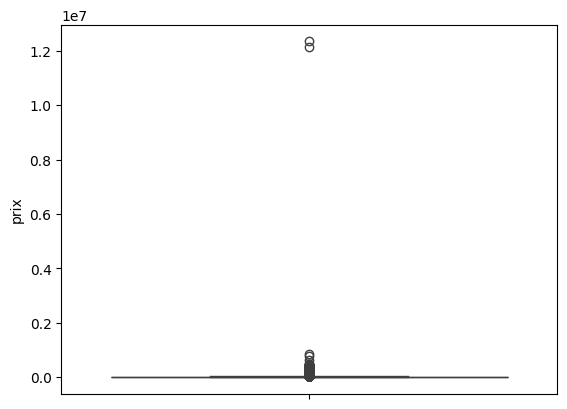

In [39]:
#Regardons les prix de plus près
sns.boxplot( y='prix', data=df_cleaned)

Les petits prix peuvent indiquer une location plutôt qu'un achat, mais la formulation des offres sur leboncoin ne permet pas toujours de distinguer.\
On se fixe un prix minimum d'achat de 1 000 euros et un prix maximum de 500 000 euros.

In [40]:
#Supprimer les lignes dont les prix sont inférieurs à 500 et supérieures à 500 000 euros
df_cleaned=df_cleaned[~((df_cleaned["prix"]>500000) | (df_cleaned["prix"]<1000))]
print("Nombres de lignes supprimées:", 79214-df_cleaned.shape[0])
print("Nouvelle taille du dataset:", df_cleaned.shape)
df_cleaned.describe(include='all')["prix"].T

Nombres de lignes supprimées: 901
Nouvelle taille du dataset: (78313, 31)


count      78313.000000
unique              NaN
top                 NaN
freq                NaN
mean       20884.303819
std        20061.841703
min         1000.000000
25%         9990.000000
50%        16990.000000
75%        25987.000000
max       489990.000000
Name: prix, dtype: float64

On constate que les valeurs des quartiles restent les mêmes.

<Axes: ylabel='prix'>

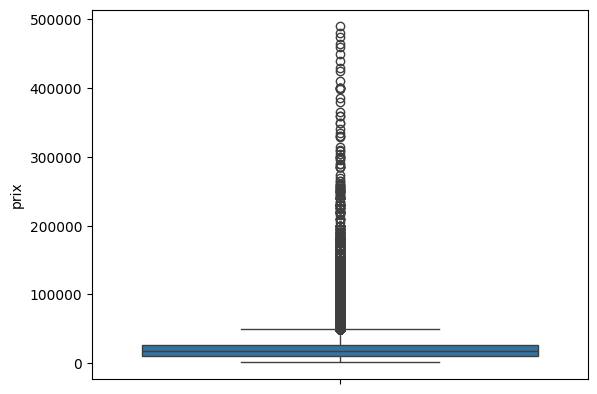

In [41]:
#Regardons les prix corrigés de plus près
sns.boxplot( y='prix', data=df_cleaned)

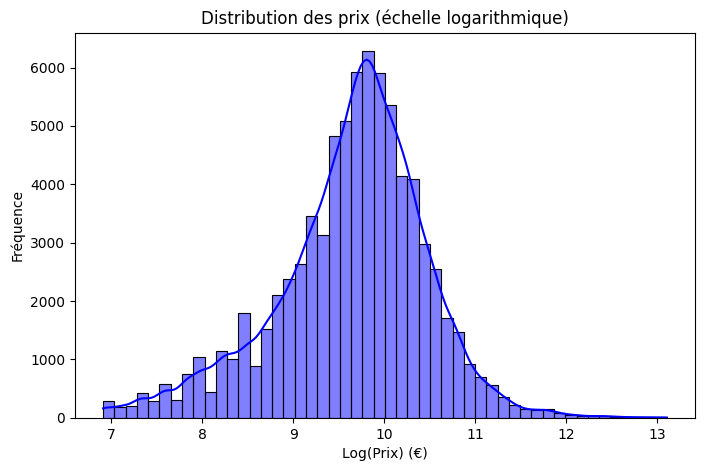

In [42]:
# Ajouter une colonne pour le logarithme des prix (en évitant les erreurs avec les valeurs nulles ou négatives)
df_cleaned['log_prix'] = np.log1p(df_cleaned['prix'])  # log(1 + prix) pour éviter log(0)

# Visualiser la distribution après transformation
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['log_prix'], bins=50, kde=True, color='blue')
plt.title('Distribution des prix (échelle logarithmique)')
plt.xlabel('Log(Prix) (€)')
plt.ylabel('Fréquence')
plt.show()

**Observation:**

* La distribution presente clairement une forme en cloche type d'une distribution normale. Cela nous facilitera l'interprétation et l'analyse des prix.
* Le pic principal est autour de la valeur log(10), ce qui correspond à environ 22 000 € 

### **4.2 Prix par kilomètre**

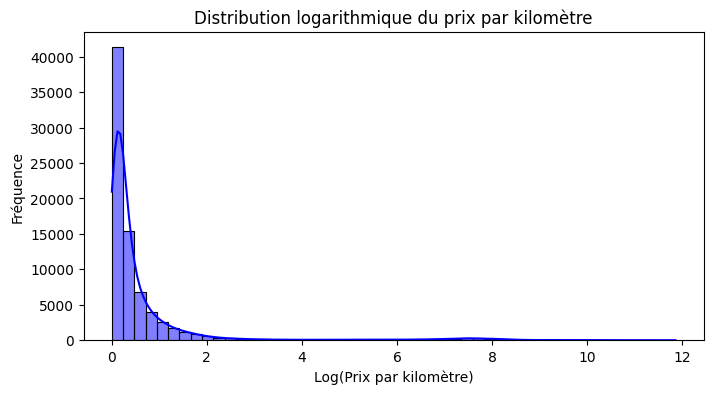

In [43]:
df_cleaned['log_prix_par_km'] = np.log1p(df_cleaned['prix_par_km'])
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_prix_par_km'], bins=50, kde=True, color='blue')
plt.title('Distribution logarithmique du prix par kilomètre')
plt.xlabel('Log(Prix par kilomètre)')
plt.ylabel('Fréquence')
plt.show()

**Observation:**

* Le graphique montre une distribution relativement asymétrique vers la gauche, ce qui indique que la majorité des véhicules ont un prix par kilomètre faible. Cependant, la présence d'une traîne à droite montre qu'il existe des véhicules avec un prix par kilomètre très élevé (outliers), ce qui peut influencer les statistiques globales.

* Nous allons donc creer des categories de prix par klm pour mieux observer les differents vehicules

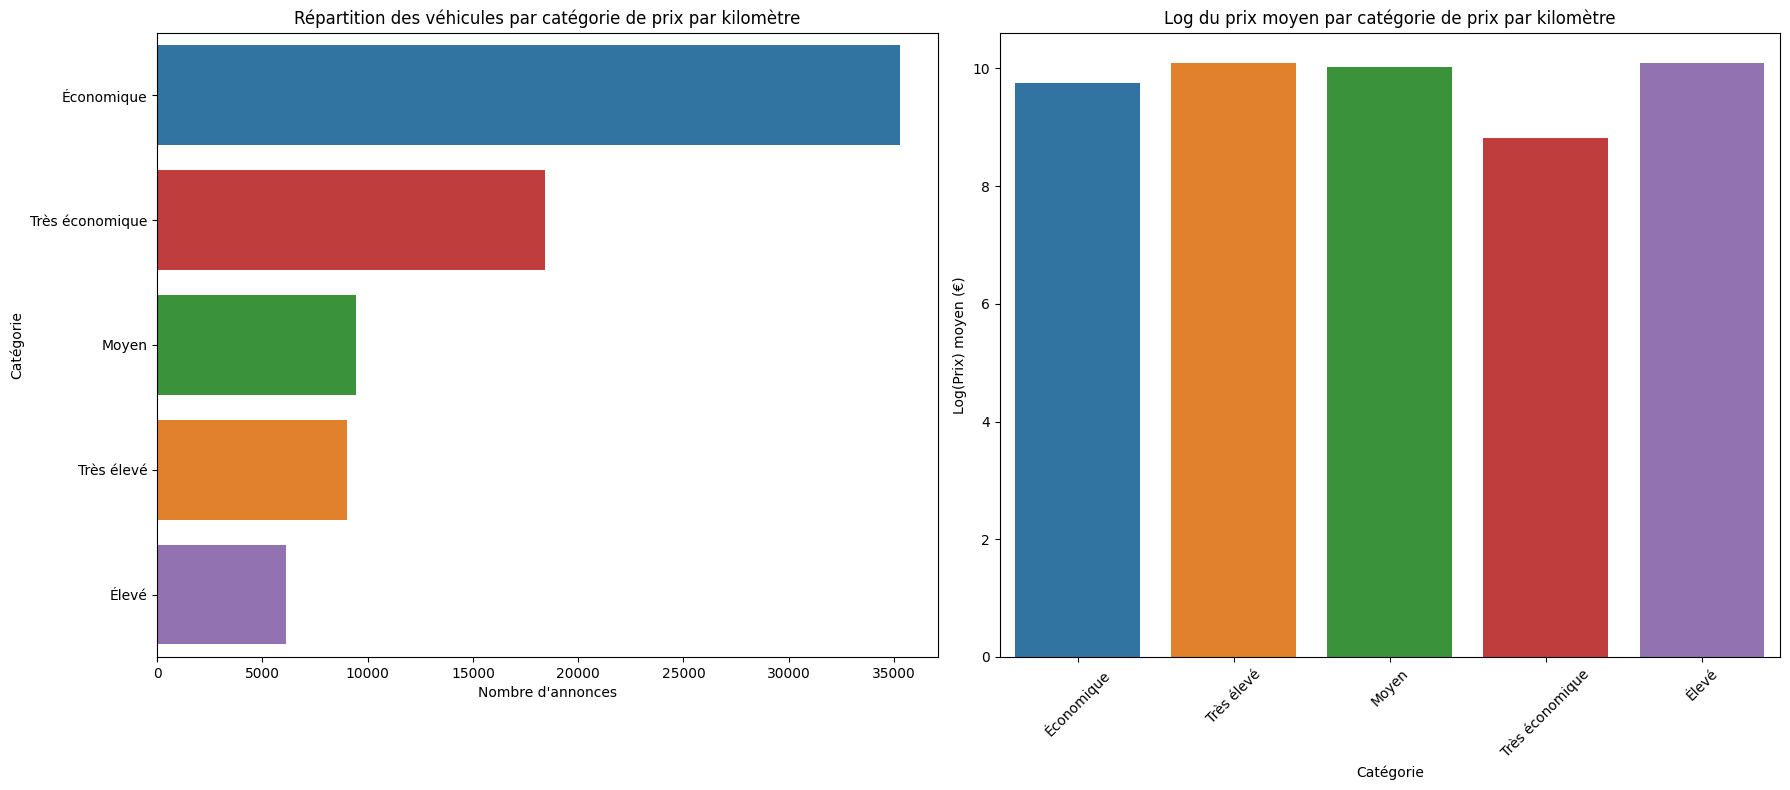

In [44]:
# Créer des catégories de prix par kilomètre
def categoriser_prix_par_km(prix_par_km):
    if prix_par_km <= 0.1:
        return 'Très économique'
    elif 0.1 < prix_par_km <= 0.5:
        return 'Économique'
    elif 0.5 < prix_par_km <= 1.0:
        return 'Moyen'
    elif 1.0 < prix_par_km <= 2.0:
        return 'Élevé'
    else:
        return 'Très élevé'

df_cleaned['categorie_prix_par_km'] = df_cleaned['prix_par_km'].apply(categoriser_prix_par_km)

# Créer une figure avec deux axes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Graphique 1 : Répartition des catégories
sns.countplot(
    data=df_cleaned, 
    y='categorie_prix_par_km', 
    order=df_cleaned['categorie_prix_par_km'].value_counts().index, hue='categorie_prix_par_km', legend=False, 
    ax=axes[0]
)
axes[0].set_title('Répartition des véhicules par catégorie de prix par kilomètre')
axes[0].set_xlabel('Nombre d\'annonces')
axes[0].set_ylabel('Catégorie')

# Graphique 2 : Log du prix moyen par catégorie
sns.barplot(
    data=df_cleaned, 
    x='categorie_prix_par_km', 
    y='log_prix', 
    estimator='mean', errorbar=None, hue='categorie_prix_par_km', legend=False, 
    ax=axes[1]
)
axes[1].set_title('Log du prix moyen par catégorie de prix par kilomètre')
axes[1].set_xlabel('Catégorie')
axes[1].set_ylabel('Log(Prix) moyen (€)')
axes[1].tick_params(axis='x', rotation=45)

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()
plt.show()

**Graphique de gauche** : Répartition des véhicules par catégorie de prix par kilomètre

* La majorité des annonces se concentrent dans les catégories Économique et Très économique, ce qui est attendu pour des véhicules courants.
* Les catégories Élevé et Très élevé contiennent un nombre relativement faible d'annonces, suggérant qu'elles représentent des cas plus rares ou des véhicules de luxe.

* Ces résultats confirment bien que le marché de l'occasion est dominé par des véhicules accessibles en termes de coût par kilomètre. Les véhicules dans les catégories élevées pourraient correspondre à des modèles premium, neufs, ou mal catégorisés (outliers).

**Graphique de droite** : Log du prix moyen par catégorie de prix par kilomètre

* Les catégories Très élevé et Élevé affichent des prix moyens (logarithmiques) plus élevés, comme attendu.
La catégorie Très économique a un log du prix moyen légèrement inférieur à celui des catégories intermédiaires (par exemple, Moyen), ce qui montre une certaine cohérence dans le lien entre le prix par kilomètre et le prix global.

* La relation entre la catégorie de prix par kilomètre et le log du prix semble globalement linéaire, avec des variations marginales dues à des facteurs supplémentaires comme la marque ou l'année.

### **4.3 Relation entre log_prix et kilométrage en fonction du type de carburant**

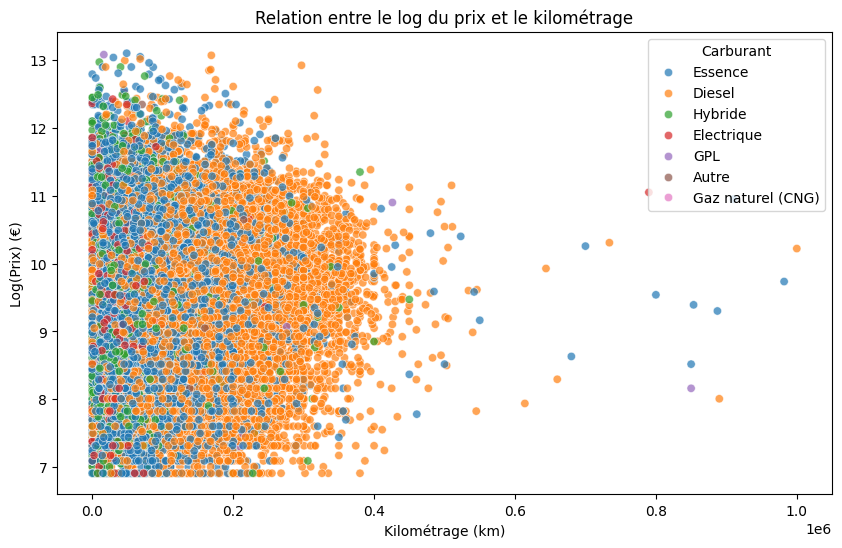

In [45]:
# 1.3 Relation entre log_prix et kilométrage
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='kilometrage', y='log_prix', hue='carburant', alpha=0.7)
plt.title('Relation entre le log du prix et le kilométrage')
plt.xlabel('Kilométrage (km)')
plt.ylabel('Log(Prix) (€)')
plt.legend(title='Carburant')
plt.show()

**Observatioons:**

* Une tendance décroissante est visible : en général, plus le kilométrage est élevé, plus le prix (logarithmique) est faible. Cependant, cette relation semble non linéaire et devient moins claire pour les kilométrages élevés.

* Le diesel (orange) domine largement les points de données, ce qui reflète sa popularité sur le marché des véhicules d'occasion. Les véhicules électriques et hybrides (vert et rose) semblent se concentrer sur des kilométrages faibles et des prix plus élevés, indiquant des modèles récents ou haut de gamme.

### **4.4 Relation entre log_prix et âge du véhicule**

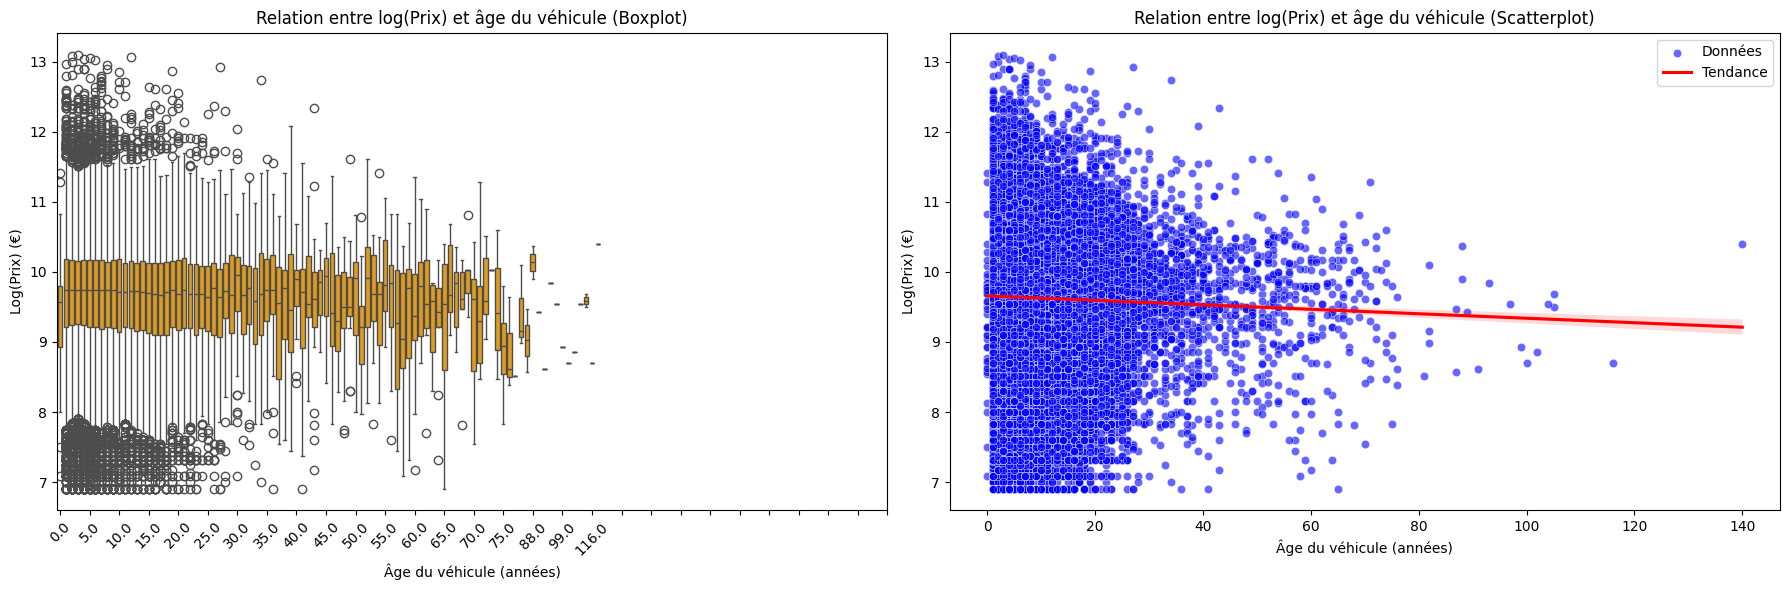

In [46]:
# Initialiser la figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot : Relation entre log_prix et âge du véhicule
sns.boxplot(data=df_cleaned, x='age_vehicule', y='log_prix', color='orange', ax=axes[0])
axes[0].set_title('Relation entre log(Prix) et âge du véhicule (Boxplot)')
axes[0].set_xlabel('Âge du véhicule (années)')
axes[0].set_ylabel('Log(Prix) (€)')
axes[0].set_xticks(range(0, int(df_cleaned['age_vehicule'].max()) + 1, 5))  # Réduction des ticks
axes[0].tick_params(axis='x', rotation=45)

# Scatterplot avec tendance
sns.scatterplot(data=df_cleaned, x='age_vehicule', y='log_prix', alpha=0.6, color='blue', ax=axes[1], label='Données')
sns.regplot(data=df_cleaned, x='age_vehicule', y='log_prix', scatter=False, color='red', ax=axes[1], label='Tendance')
axes[1].set_title('Relation entre log(Prix) et âge du véhicule (Scatterplot)')
axes[1].set_xlabel('Âge du véhicule (années)')
axes[1].set_ylabel('Log(Prix) (€)')
axes[1].legend()

# Ajustement des espaces entre les graphiques
plt.tight_layout()
plt.show()

**Observation:**

* Le Boxplot laisse apparaitre une forte concentration des prix pour les véhicules âgés de moins de 10 ans avec moins de variabilité. Les voitures plus anciennes tendent à avoir un prix log réduit, ce qui reflète la dépréciation naturelle des voitures avec le temps.

* Le graphe de nuage des points vient confirmer la corrélation globale entre l'âge et le log du prix observable dadns le graphe 1, avec la ligne de tendance en rouge. La pente négative de cette ligne confirme que le prix diminue avec l'âge. Les valeurs aberrantes sont donc identifiées par des points dispersés au-dessus de la tendance.

### **4.5 Variables catégoriques : marque**

C:\Users\Annek\AppData\Local\Temp\ipykernel_21456\1985351688.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prix_moyen_par_marque.index, y=prix_moyen_par_marque.values, palette='viridis')


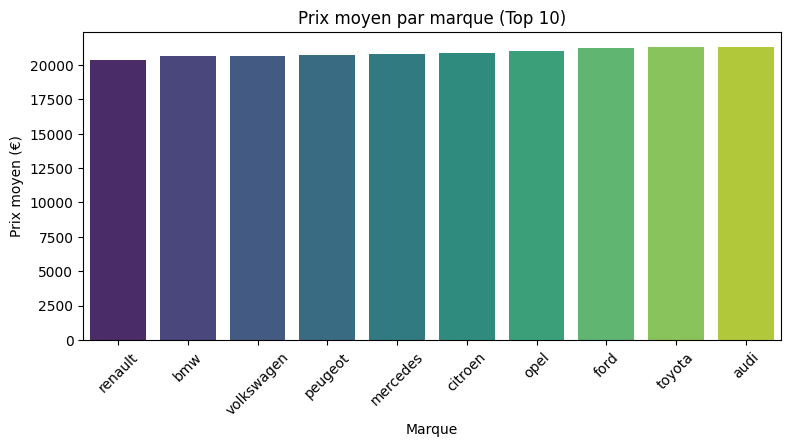

In [47]:
plt.figure(figsize=(9, 4))
marques_top = df_cleaned['marque'].value_counts().head(10).index
# Calculer le prix moyen pour les marques top 10
prix_moyen_par_marque = df_cleaned[df_cleaned['marque'].isin(marques_top)].groupby('marque')['prix'].mean().sort_values()

# Tracer le graphique trié
sns.barplot(x=prix_moyen_par_marque.index, y=prix_moyen_par_marque.values, palette='viridis')
plt.title('Prix moyen par marque (Top 10)')
plt.xlabel('Marque')
plt.ylabel('Prix moyen (€)')
plt.xticks(rotation=45)
plt.show()

**Observations:**

* Les marques ont des prix moyens relativement proches, indiquant une gamme de prix homogène pour les véhicules les plus populaires.
* Les marques comme BMW et Mercedes sont légèrement plus chères que les autres, ce qui reflète leur positionnement premium.

C:\Users\Annek\AppData\Local\Temp\ipykernel_21456\28662077.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prix_region.values, y=prix_region.index, palette='magma')


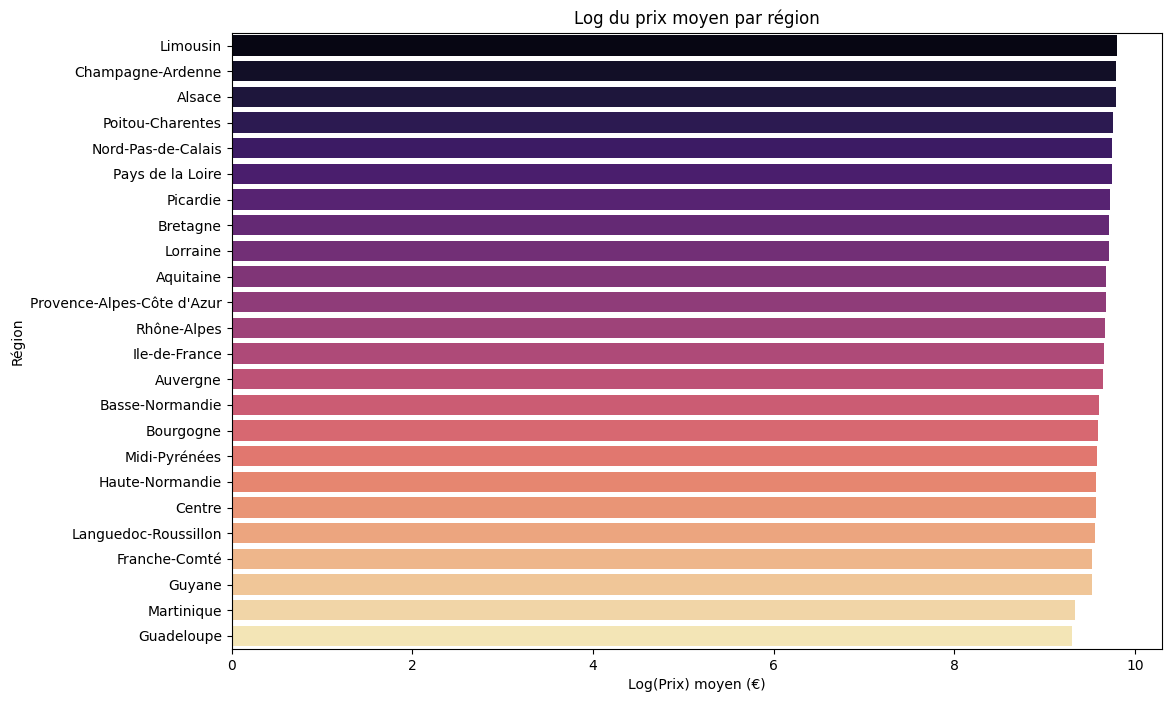

In [48]:
# Log du prix moyen par région
plt.figure(figsize=(12, 8))
prix_region = df_cleaned.groupby('region')['log_prix'].mean().sort_values(ascending=False)
sns.barplot(x=prix_region.values, y=prix_region.index, palette='magma')
plt.title('Log du prix moyen par région')
plt.xlabel('Log(Prix) moyen (€)')
plt.ylabel('Région')
plt.show()

C:\Users\Annek\AppData\Local\Temp\ipykernel_21456\2982931893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='booste', y='log_prix', palette='Set2')


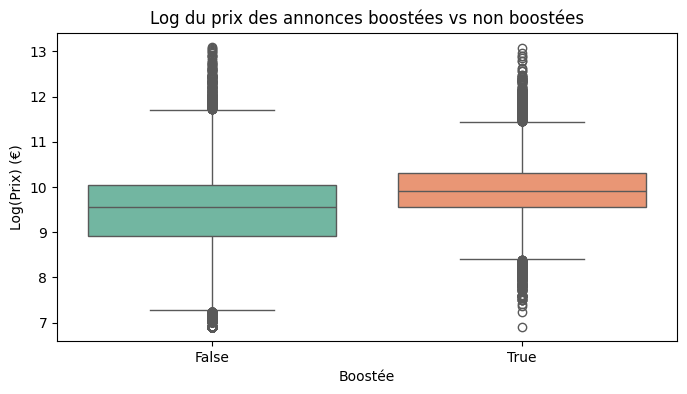

In [49]:
# Analyse des annonces boostées
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_cleaned, x='booste', y='log_prix', palette='Set2')
plt.title('Log du prix des annonces boostées vs non boostées')
plt.xlabel('Boostée')
plt.ylabel('Log(Prix) (€)')
plt.show()

C:\Users\Annek\AppData\Local\Temp\ipykernel_21456\2442687031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='plaque_disponible', y='log_prix', palette='cool')


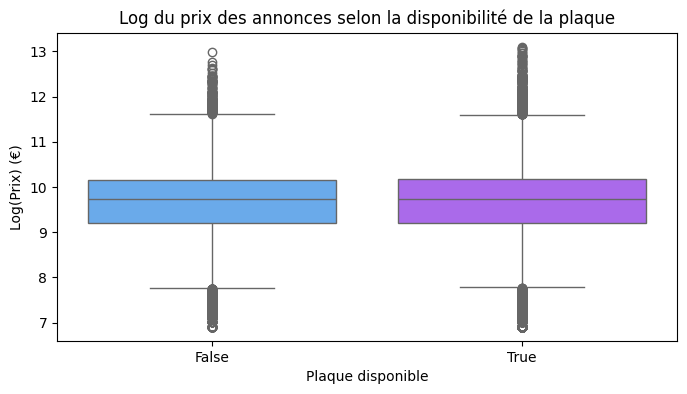

In [50]:
# Relation entre plaque_disponible et log_prix
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_cleaned, x='plaque_disponible', y='log_prix', palette='cool')
plt.title('Log du prix des annonces selon la disponibilité de la plaque')
plt.xlabel('Plaque disponible')
plt.ylabel('Log(Prix) (€)')
plt.show()

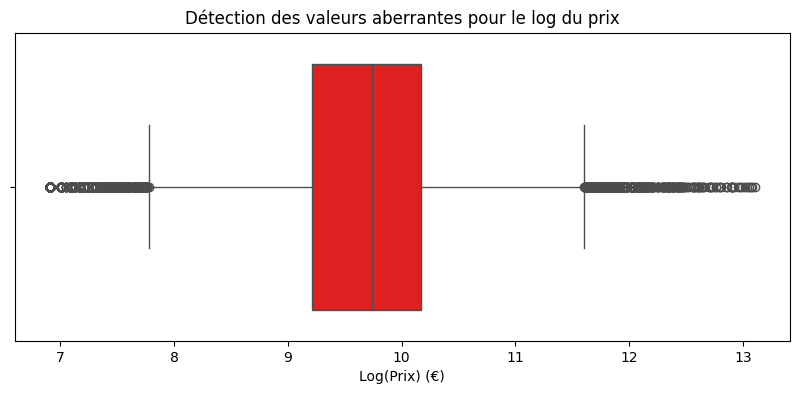

In [51]:
# 5. Détection des valeurs aberrantes
# Boxplot pour identifier les outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_cleaned, x='log_prix', color='red')
plt.title('Détection des valeurs aberrantes pour le log du prix')
plt.xlabel('Log(Prix) (€)')
plt.show()

# Modelling (Pas encore touche)

In [52]:
#import libraries
import warnings
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error

In [53]:
#Target vs variables
y = df_cleaned["prix"]
#enlever les variables crées à partir du prix
X = df_cleaned.drop(["prix","log_prix","prix_par_km","log_prix_par_km","categorie_prix_par_km"], axis=1) #

In [54]:
#Dissocier les variables numériques des variables catégorielles
numerical_features=X.columns[~X.columns.isin(X.select_dtypes(include='object').columns)]
categorical_features=X.columns[X.columns.isin(X.select_dtypes(include='object').columns)]

In [55]:
#train_test split
X_train,X_test,y_train,y_test=train_test_split(X, y, random_state = 0,test_size=0.2, train_size=0.8)

__Premier test__: tester plusieures algorithms avec une paramétrisation plus ou moins similaire pour choisir le meilleur

In [56]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')), 
            ('scale', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Models and parameter grids
models = [
    ('linear_reg', LinearRegression()),
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('xgboost', XGBRegressor(random_state=42)),
    ('catboost', CatBoostRegressor(verbose=0, random_state=42)),
    ('lightgbm', LGBMRegressor(random_state=42,force_col_wise=True,verbose=-1))
]
param_grids = {
    'linear_reg': {},
    'decision_tree': {
        'classifier__max_depth': [2, 5, 10],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 5, 10]
    },
    'random_forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [2, 5],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 5,10]
    },
    'xgboost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [2, 5],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__min_child_weight': [1, 5,10]
    },
    'catboost': {
        'classifier__iterations': [100, 200],
        'classifier__max_depth': [2, 5],
        'classifier__learning_rate': [0.1, 0.01]
    },
    'lightgbm': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__num_leaves': [20, 50]
    }
}

# Define pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())  # Placeholder for models
])

# Define scoring metric (Negative Mean Squared Error for GridSearchCV)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Store the best models
best_models = {}

# Perform GridSearchCV for each model
for name, model in models:
    print(f"Training {name}...")
    # Update pipeline with the model
    pipe.set_params(classifier=model)
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        pipe,
        param_grids.get(name, {}),  # Default to an empty grid if not defined
        cv=5,
        scoring=scorer,
        refit=True,
        verbose=1
    )
    # Fit the model
    grid_search.fit(X_train, y_train)
    # Store results for the model
    best_models[name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': np.sqrt(-grid_search.best_score_)  # RMSE
    }

# Display results
for name, result in best_models.items():
    print(f"Model: {name}")
    print(f"Best RMSE: {result['best_score']}")
    print(f"Best Parameters: {result['best_params']}\n")


Training linear_reg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training decision_tree...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Training random_forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Training xgboost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Training catboost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training lightgbm...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model: linear_reg
Best RMSE: 24846.942052578608
Best Parameters: {}

Model: decision_tree
Best RMSE: 18802.168650385975
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}

Model: random_forest
Best RMSE: 18924.224727914057
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Model: xgboost
Best RMSE: nan
Best Parameters: {'classifi

In [57]:
#erreur de prédiction
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMRegressor(random_state=42,
                          learning_rate=0.1,
                          n_estimators=200,
                          num_leaves=20,
                          force_col_wise=True,
                          verbose=-1)) 
])

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
print ("rmse=", np.sqrt(mean_squared_error(y_test, y_pred)))

rmse= 18204.264113733883


Le meilleur modèle est le lightGBM avec un RMSE de 18 204 ce qui est assez élevé pour une moyenne de 20 884, une médiane de 16 990 et une std de 20 661.

**Deuxième test**

In [59]:
warnings.filterwarnings("ignore")

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),  # Replace with your numerical columns
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)  # Replace with your categorical columns
    ]
)

# Model and parameter grid
model = LGBMRegressor(random_state=42,force_col_wise=True,verbose=-1)
param_grid = {
    'classifier__max_depth': [None] + [i for i in range(2, 8)],
    'classifier__num_leaves': [i for i in range(50, 151, 50)],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__n_estimators': [i for i in range(50, 301, 50)],
    'classifier__subsample': [i / 10 for i in range(7, 11)]
}

# Define pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)  # Single model
])

# Define the scoring metric (Mean Squared Error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform GridSearchCV
print("Training LightGBM...")
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring=scorer,
    refit=True,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best model details
best_model = {
    'best_estimator': grid_search.best_estimator_,
    'best_params': grid_search.best_params_,
    'best_score': -grid_search.best_score_  # Convert negative MSE to positive
}

# Display results
print("Best Model Details:")
print(f"Best MSE: {best_model['best_score']}")
print(f"Best Params: {best_model['best_params']}")


Training LightGBM...
Fitting 5 folds for each of 1512 candidates, totalling 7560 fits
Best Model Details:
Best MSE: 337710428.10860205
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__n_estimators': 200, 'classifier__num_leaves': 50, 'classifier__subsample': 0.7}


In [62]:
warnings.filterwarnings("ignore")
#erreur de prédiction
best_pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMRegressor(random_state=42,
                          learning_rate=0.1,
                          max_depth=None,
                          n_estimators=200,
                          num_leaves=50,
                          subsample=0.7,
                          force_col_wise=True,
                          verbose=-1)) 
])

best_pipe_lgbm.fit(X_train, y_train)
y_pred_lgbm = best_pipe_lgbm.predict(X_test)
print ("rmse=", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))

rmse= 18153.806109698406


Le meilleur modèle nous donne un RMSE de 18 153 ce qui est une légère amélioration mais reste élevé.

**3ème test**: Comme l'intervalle de prix est large, essayons de modéliser le log des prix.

In [71]:
df_cleaned.describe()["log_prix"].T

count    78313.000000
mean         9.633981
std          0.829394
min          6.908755
25%          9.209440
50%          9.740439
75%         10.165390
max         13.102142
Name: log_prix, dtype: float64

In [72]:
#Target vs variables
y_log = df_cleaned["log_prix"]
#enlever les variables crées à partir du prix
X_log = df_cleaned.drop(["prix","log_prix","prix_par_km","log_prix_par_km","categorie_prix_par_km"], axis=1) #
#train_test split
X_train_log,X_test_log,y_train_log,y_test_log=train_test_split(X_log, y_log, random_state = 0,test_size=0.2, train_size=0.8)

In [73]:
warnings.filterwarnings("ignore")
#erreur de prédiction
best_pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMRegressor(random_state=42,
                          learning_rate=0.1,
                          max_depth=None,
                          n_estimators=200,
                          num_leaves=50,
                          subsample=0.7,
                          force_col_wise=True,
                          verbose=-1)) 
])

best_pipe_lgbm.fit(X_train_log, y_train_log)
y_pred_lgbm_log = best_pipe_lgbm.predict(X_test_log)
print ("rmse=", np.sqrt(mean_squared_error(y_test_log, y_pred_lgbm_log)))

rmse= 0.7308453000071053


Exp(rmse)=2,08 ce qui signifie que le prix prédit peut être 2 fois moins ou 2 fois plus que le vrai prix, ce qui est assé elevé.

**Feature importance**

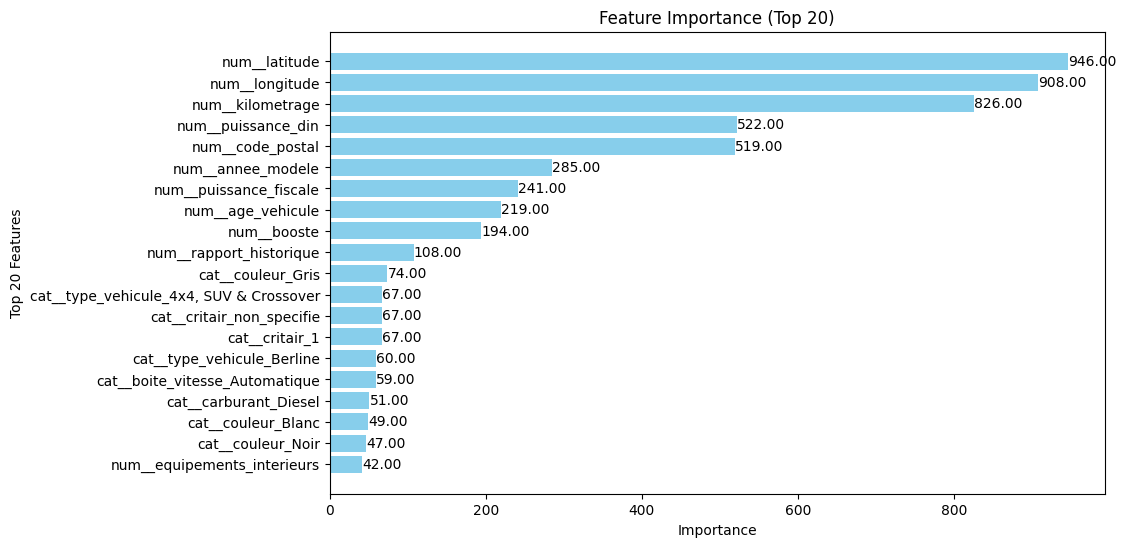

In [75]:
feature_importance = best_pipe_lgbm.named_steps['classifier'].feature_importances_
feature_names = best_pipe_lgbm.named_steps['preprocessor'].get_feature_names_out()
# Créer un DataFrame pour une meilleure visualisation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Tracer les importances
plt.figure(figsize=(10, 6))
bars=plt.barh(feature_importance_df.head(20)['Feature'], feature_importance_df.head(20)['Importance'], color='skyblue')
for bar, value in zip(bars, feature_importance_df.head(20)['Importance']):
    plt.text(
        bar.get_width() + 0.01, 
        bar.get_y() + bar.get_height() / 2, 
        f"{value:.2f}", 
        va='center'
    )
plt.xlabel('Importance')
plt.ylabel('Top 20 Features')
plt.title('Feature Importance (Top 20)')
plt.gca().invert_yaxis()  # Inverser pour avoir les plus importantes en haut
plt.show()

Garder le top 20 pour la suite de la modélisation\
Pistes d'amélioration à tester:
- log transformation des features numériques
- polynomial features
- Label encoding?
- Approfondir le Feature engineering